In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import seaborn as sns
from scipy import stats
from statsmodels.stats import multitest
import ptitprince as pt
import copy

In [19]:
import popoff
import pop_off_plotting as pop
from Session import SessionLite
from linear_model import PoolAcrossSessions, LinearModel, MultiSessionModel

In [4]:
figure_path = '/home/jrowland/Documents/figures/s1s2_paper/0/'

def save_figure(name, base_path='/home/jrowland/mnt/qnap/Figures/josh_thesis'):
    plt.rcParams['pdf.fonttype'] = 42
    plt.savefig(os.path.join(base_path, f'{name}.pdf'), 
                bbox_inches='tight', transparent=True)

In [5]:
from matplotlib import rcParams

params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}

plt.rc("axes.spines", top=False, right=False) # despine

COLORS = [
'#228E5E', # Hit green
'#DB3713', # Miss red
'#0085BD',  # Correct Rejection
'#E7A01E', # False postive 
'#5A1EE7'  # Spont
]

## MAKE THE FONT SIZE 20 or 21
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.size'] = 14


rcParams.update(params)


In [6]:
msm = MultiSessionModel(remove_targets=False, subsample_sessions=False,
                         remove_toosoon=True)

long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time
ALERT SESSIONS NOT SUBSAMPLED
long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time


In [10]:
def baseline_subtraction(flu, lm):
    
    ''' Takes a cell averaged flu matrix [n_trials x time]
        and subtracts pre-stim activity of an individual trial 
        from every timepoint in that trial.
        '''
    baseline = np.mean(flu[:, lm.frames_map['pre']], 1)
    flu = np.subtract(flu.T, baseline).T
    return flu

In [11]:
def session_flu(lm, region, outcome, frames, n_cells, subtract_baseline=True):

    # Select region and trial outcomes
    if outcome != 'pre_reward':
        flu = lm.flu
        outcome_bool = lm.session.outcome == outcome
        
        if outcome in ['hit', 'miss']:
            n_stimmed_bool = np.isin(lm.session.trial_subsets, n_cells)
            outcome_bool = np.logical_and(outcome_bool, n_stimmed_bool)
        
        flu = flu[:, outcome_bool, :]
    else:
        flu = lm.pre_flu
    
    flu = flu[lm.region_map[region], :, :]
    # Mean across cells
    flu = np.mean(flu, 0)
    
    if subtract_baseline:
        flu = baseline_subtraction(flu, lm)
        
    # Select desired frames
    if frames != 'all':
        flu = flu[:, lm.frames_map[frames]]
    
    return flu

In [12]:
def s1_s2_plot(msm, n_cells):

    plt.figure(figsize=(16,6))
    frames = 'all'
    tts_plot = ['hit', 'miss', 'fp', 'cr','pre_reward']
#     tts_plot = ['hit', 'miss']
#     tts_plot = ['fp', 'cr', 'pre_reward']
    
    ylims = (-0.05, 0.07)

    plt.subplot(1,2,1)
    plt.suptitle(f'Number of cells stimmed = {n_cells}', fontsize=25)
    region = 's1'
    stack = 'all-trials'
    for tt in tts_plot:
        multisesssion_flu(msm, region=region, outcome=tt, frames=frames, n_cells=n_cells,
                          stack=stack)
        
    plt.title(region.upper(), fontsize=18)
    plt.ylim(ylims)

    plt.subplot(1,2,2)
    region = 's2'
    for tt in tts_plot:
        multisesssion_flu(msm, region=region, outcome=tt, frames=frames, n_cells=n_cells,
                          stack=stack)

    plt.title(region.upper(), fontsize=18)
    leg = plt.legend(bbox_to_anchor=[1, 0.5])
    lines = leg.get_lines()
    _ = [line.set_linewidth(10) for line in lines]
    plt.ylim(ylims)

    name_plot  = '-'.join(tts_plot)
#     save_figure('Figure2_grandAverageTraces', figure_path)
    

In [13]:
def multisesssion_flu(msm, region, outcome, frames, n_cells, stack='all-trials'):
    
    if outcome == 'hit':
        color = COLORS[0]
    elif outcome == 'miss':
        color = COLORS[1]
    elif outcome == 'pre_reward':
        color = COLORS[4]
    elif outcome == 'fp':
        color = COLORS[3]
    elif outcome == 'cr':
        color = COLORS[2]
        
    flu = []
    for lm in msm.linear_models:
        sf = session_flu(lm, region=region, outcome=outcome, frames=frames, 
                         n_cells=n_cells)
        if stack == 'all-trials':
            flu.append(sf)  # stack every trial from every session in a big array
        else:
            flu.append(np.mean(sf, 0))  # stack the session mean into a big array
    
    flu = np.vstack(flu)
    mean_flu = np.mean(flu, 0)
    z = 1.96
    ci = z * (np.std(flu, 0) / flu.shape[0])
    
    if outcome not in ['pre_reward', 'fp', 'cr']:
        # Remove the artifact
        artifact_frames = np.where((lm.times_use>-0.07) & (lm.times_use<0.9))
        mean_flu[artifact_frames] = np.nan
    label = outcome.capitalize()
#     else:
#         label = 'Spontaneous\nReward'
    
    plt.plot(mean_flu, color=color, label=label)
    plt.fill_between(np.arange(len(mean_flu)), mean_flu+ci, mean_flu-ci, color=color)
    
    times_axis = np.logical_and(np.floor(lm.times_use) == np.ceil(lm.times_use), 
                                np.mod(lm.times_use, 2)==0)
    times_axis = np.logical_and(times_axis, lm.times_use>=-2)
    
    plt.xticks(np.where(times_axis)[0], lm.times_use[times_axis])
    
    plt.xlabel('time (seconds)', fontsize=28)
    plt.axhline(0, ls=':', color='grey')
    
    plt.xlim(np.where(lm.times_use==-2)[0],np.where(lm.times_use==6)[0])

    if region != 's2': plt.ylabel(r'$\Delta$F/F', fontsize=28)

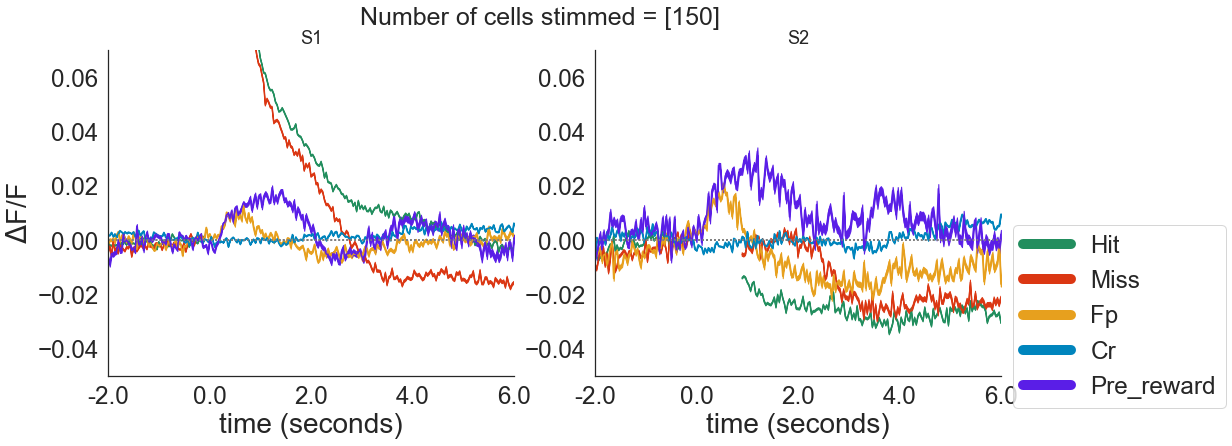

In [14]:
# for n_cells in [[5,10], [20,30], [40,50], [150]]:
for n_cells in [[150]]:
    s1_s2_plot(msm, n_cells)

save_figure('Figure2supp_grandAv_150_allTTs', figure_path)

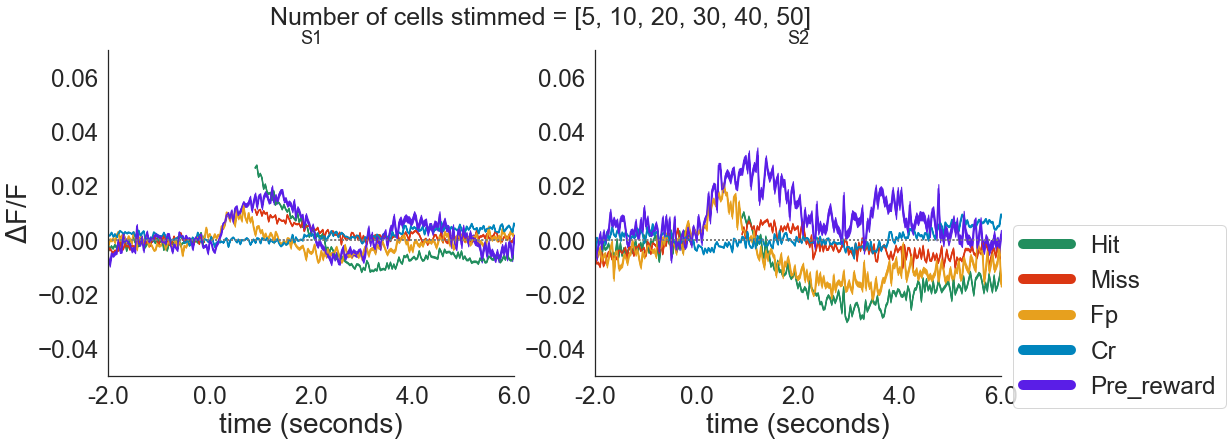

In [15]:
# for n_cells in [[5,10], [20,30], [40,50], [150]]:
for n_cells in [[5,10,20,30,40,50]]:
    s1_s2_plot(msm, n_cells)

save_figure('Figure2supp_grandAv_5-50_allTTs', figure_path)

Text(0.5, 1.15, 'Cells responding S2')

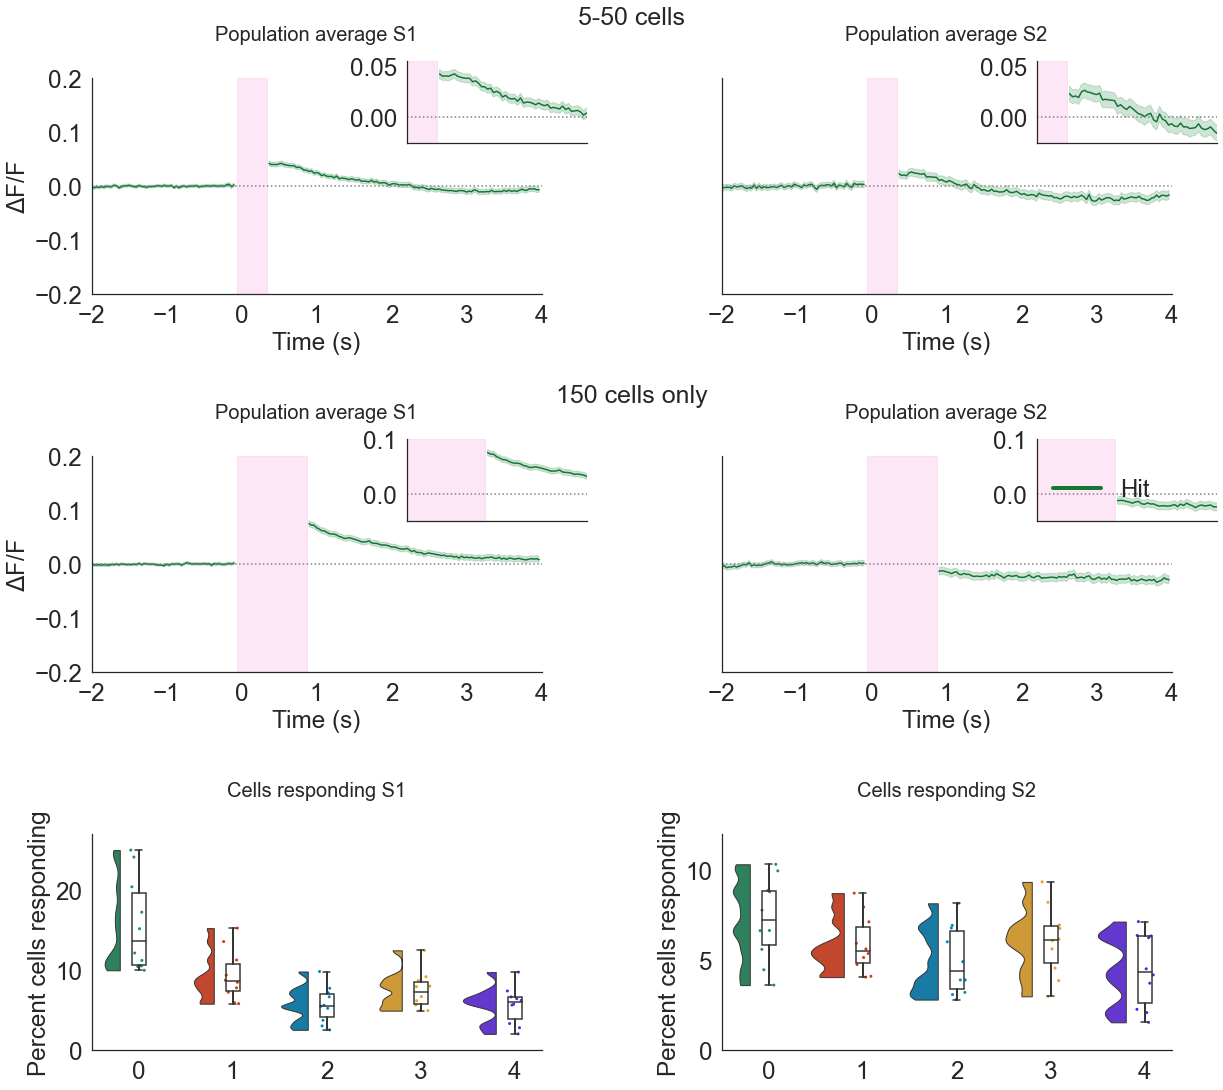

In [199]:
fig = plt.figure(constrained_layout=False, figsize=(15, 15))

tts = ['hit', 'miss', 'fp', 'cr', 'pre_reward']
tts = ['hit']

without_150 = fig.add_gridspec(ncols=2, nrows=1, bottom=0.8, top=1, right=1, left=0,
                               wspace=0.4, hspace=0.7)

only_150 = fig.add_gridspec(ncols=2, nrows=1, bottom=0.45, top=0.65, right=1, left=0,
                            wspace=0.4, hspace=0.7)

rains = fig.add_gridspec(ncols=2, nrows=1, bottom=0.1, top=0.3, right=1, left=0,
                            wspace=0.4, hspace=0.7)

fig.text(0.5, 1.05, '5-50 cells', size=25, ha="center")
fig.text(0.5, 0.7, '150 cells only', size=25, ha="center")

ax_pop_activity = {xx: fig.add_subplot(without_150[xx]) for xx in range(2)}

for n_cells in [[5, 10, 20, 30, 40, 50]]:
    tmp = pop.plot_average_tt_s1_s2(msm, n_cells, tts_plot=tts,
                                   ax_s1=ax_pop_activity[0], ax_s2=ax_pop_activity[1],
                                   plot_legend=False)
    
ax_pop_activity[0].set_title('Population average S1', y=1.15, fontsize=20)
ax_pop_activity[1].set_title('Population average S2', y=1.15, fontsize=20)
    
ax_pop_activity = {xx: fig.add_subplot(only_150[xx]) for xx in range(2)}

for n_cells in [[150]]:
    tmp = pop.plot_average_tt_s1_s2(msm, n_cells, tts_plot=tts,
                                   ax_s1=ax_pop_activity[0], ax_s2=ax_pop_activity[1],
                                   plot_legend=True, zoom_ylims=(-0.05, 0.1))
    
ax_pop_activity[0].set_title('Population average S1', y=1.15, fontsize=20)
ax_pop_activity[1].set_title('Population average S2', y=1.15, fontsize=20)

ax_rains = [fig.add_subplot(rains[xx]) for xx in range(2)]

percent_responding_tts(ax_rains)

ax_rains[0].set_title('Cells responding S1', y=1.15, fontsize=20)
ax_rains[1].set_title('Cells responding S2', y=1.15, fontsize=20)

In [16]:
def get_percent_cells_responding(session, region, direction='positive', prereward=False):

    # 0.015 gives you 5% of cells responding (positive + negative)
    # on cr (for session 0)
    # Get me for 5% across all 
    fdr_rate = 0.015

    if not prereward:
        flu = session.behaviour_trials
    else:
        flu = session.pre_rew_trials
        
    times_use = session.filter_ps_time
    
    if region == 's1':
        flu = flu[session.s1_bool, :, :]
    elif region == 's2':
        flu = flu[session.s2_bool, :, :]
    
    percent_cells_responding = []
    
    magnitude = []

    for trial_idx in range(flu.shape[1]):

        # Haven't built this for 5 Hz data
        assert session.mouse not in ['J048', 'RL048']

        trial = flu[:, trial_idx, :]

        # 500 ms before the stim with a nice 
        # juicy buffer to the artifact just in case
        pre_idx = np.where(times_use < -0.15)[0][-15:]  

        # You can dial this back closer to the artifact if you cut out 150
        post_idx = np.logical_and(times_use > 1, times_use <= 1.5)
        
        pre_array = trial[:, pre_idx]
        post_array = trial[:, post_idx]
        
        p_vals = [stats.wilcoxon(pre, post)[1] for pre, post in zip(pre_array, post_array)]
        p_vals = np.array(p_vals)
        
        sig_cells, correct_pval, _, _ = multitest.multipletests(p_vals, alpha=fdr_rate, method='fdr_bh',
                                                            is_sorted=False, returnsorted=False)
        
        # This doesn't split by positive and negative
#         percent_cells_responding.append(sum(sig_cells))
        
        positive = np.mean(post_array, 1) > np.mean(pre_array, 1)
        negative = np.logical_not(positive)
        
        
        if direction == 'positive':
            percent_cells_responding.append(sum(np.logical_and(sig_cells, positive)))
            magnitude.append(
                np.sum(np.mean(post_array[positive, :], 1) - 
                        np.mean(pre_array[positive, :] , 1))
            )
        else:
            percent_cells_responding.append(sum(np.logical_and(sig_cells, negative)))
        
            magnitude.append(
                np.sum(np.mean(post_array[negative, :], 1) - 
                        np.mean(pre_array[negative, :] , 1))
            )
        
    if region == 's1':
        n = sum(session.s1_bool)
    elif region == 's2':
        n = sum(session.s2_bool)
        
    percent_cells_responding = np.array(percent_cells_responding) / n * 100
    
    assert len(percent_cells_responding) == flu.shape[1]
    assert len(magnitude) == flu.shape[1]
    return percent_cells_responding

In [17]:
def get_data_dict(region):
    
    ''' Gets the percent cells responding across all trials for individual sessions
        Hit and miss trials, only when n_cells_stimmed > 20 (50% behaviour 
        sigmoid threshold)
    '''

    tt_plot = ['hit', 'miss', 'cr', 'fp', 'spont']

    data_dict = {k:[] for k in tt_plot}

    for session_idx in range(len(msm.linear_models)):
        session = msm.linear_models[session_idx].session

        n_responders =  get_percent_cells_responding(session, region, direction='positive')\
                        + get_percent_cells_responding(session, region, direction='negative')

        for tt in tt_plot:

            if tt == 'spont':
                continue

            tt_idx = session.outcome == tt

#             if tt in ['hit', 'miss']:
#                 tt_idx = np.logical_and(tt_idx, session.trial_subsets>20)

            data_dict[tt].append(
                np.mean(n_responders[tt_idx])
            )

        n_responders =  get_percent_cells_responding(session, region, direction='positive', prereward=True)\
                        + get_percent_cells_responding(session, region, direction='negative', prereward=True)

        data_dict['spont'].append(np.mean(n_responders))

    return {k:np.array(v) for k, v in data_dict.items()}
    
    

In [198]:
def percent_responding_tts(axes):

    for idx, (region, ax) in enumerate(zip(['s1', 's2'], axes)):

        data_dict = get_data_dict(region)

        pt.RainCloud(data=list(data_dict.values()), palette=COLORS, ax=ax)
        ax.set_xticks(range(len(data_dict)), data_dict.keys())
        ax.set_ylabel('Percent cells responding')

        if region == 's1':
            ax.set_ylim(0, 27)
        else:
            ax.set_ylim(0, 12)

In [200]:
data_dict

{'hit': array([24.15918389, 25.02665245, 15.1968133 , 10.46908978, 10.00278474,
        17.26443769, 11.23698459, 20.43123952, 12.16223476, 10.54602799]),
 'miss': array([ 8.5031348 , 13.59275053,  7.25344386,  5.82744907,  5.97182612,
        11.28759398,  9.40342022, 15.27199877,  7.80578898,  8.76110744]),
 'cr': array([5.50106179, 6.68030814, 3.74915101, 2.56006006, 3.05215093,
        7.75      , 5.25301958, 9.84868364, 7.18954248, 5.63702152]),
 'fp': array([ 8.72145096,  6.19977038,  5.67353407,  4.95495495,  4.98304585,
         9.19642857,  6.70553936, 12.49550521,  7.95698925,  8.02122347]),
 'spont': array([6.67711599, 6.45522388, 3.34565945, 2.82282282, 2.05513784,
        6.23015873, 5.65597668, 9.77346278, 5.76470588, 7.41573034])}

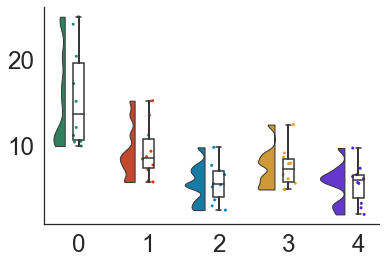

In [206]:

fig, ax = plt.subplots()
pt.RainCloud(data=list(data_dict.values()), palette=COLORS, ax=ax)
ax.set_xticks(range(len(data_dict)), list(data_dict.keys()))

In [205]:
data_dict.keys()

dict_keys(['hit', 'miss', 'cr', 'fp', 'spont'])